<a href="https://colab.research.google.com/github/eddylim95/CZ4042_NeuralNet_project/blob/master/Assignment_2/start_project_2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# For google colab use
%tensorflow_version 1.x
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/My Drive/CZ4042_NeuralNet_project'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/CZ4042_NeuralNet_project


In [0]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'Assignment_2'))
	print(os.getcwd())
except:
	pass

import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm_notebook as tqdm
import sys

NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 1000
batch_size = 128

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  #python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    
    labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
    labels_[np.arange(labels.shape[0]), labels-1] = 1

    return data, labels_

def cnn(images, num_filter_1, num_filter_2, dropout=False):
    # NHWC format
    images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
    
    #Conv 1, 50 filters of window size 9x9, VALID padding, and ReLU
    W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, num_filter_1], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
    b1 = tf.Variable(tf.zeros([num_filter_1]), name='biases_1')

    conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
    pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')

    #Conv 2, 60 filters of window size 5x5, VALID padding, and ReLU
    W2 = tf.Variable(tf.truncated_normal([5, 5, num_filter_1, num_filter_2], stddev=1.0/np.sqrt(num_filter_1*5*5)), name='weights_2')
    b2 = tf.Variable(tf.zeros([num_filter_2]), name='biases_2')

    conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1, 1, 1, 1], padding='VALID') + b2)
    pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')

    # Fully connected layer of size 300
    dim = pool_2.get_shape()[1].value * pool_2.get_shape()[2].value * pool_2.get_shape()[3].value
    pool_2_flat = tf.reshape(pool_2, [-1, dim])
    W3 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), name='weights_3')
    b3 = tf.Variable(tf.zeros([300]), name='biases_3')
    f3 = tf.matmul(pool_2_flat, W3) + b3

    # Dropout
    keep_prob = 1
    if dropout:
        keep_prob = tf.placeholder(tf.float32)
        f3 = tf.nn.dropout(f3, keep_prob)

    #Softmax, size 10. Note that softmax happens at softmax_entropy step
    W4 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(dim)), name='weights_4')
    b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
    f4 = tf.matmul(f3, W4) + b4

    return conv_1, pool_1, conv_2, pool_2, f4, keep_prob

def plot_acc(filename: str, epochs: int, test_acc: list):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    ax.plot(range(epochs), test_acc, label=f'Test accuracy')
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()

def plot_cost(filename: str, epochs: int, train_cost: list):
    fig, ax = plt.subplots(figsize=[12.8,9.6])
    ax.plot(range(epochs), train_cost, label=f'Train cost')
    ax.legend(loc='best')
    plt.savefig(filename)
    plt.show()

def plot_layer(filename, layer, num_filters):
    """Note that there is an assumption that num_filters is a multiple of 10
    """
    plt.figure()
    plt.gray()
    layer_ = np.array(layer)
    for i in range(num_filters):
        plt.subplot(num_filters/10, 10, i+1)
        plt.axis('off')
        plt.imshow(layer_[0,:,:,i])
    plt.savefig(filename)

def plot_feature_maps(X, conv_1, pool_1, conv_2, pool_2, i):
    # Test pattern
    plt.figure()
    plt.gray()
    X_show = X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
    plt.axis('off')
    plt.imshow(X_show)
    plt.savefig(f'partA_plots/q1a_test_pattern_{i}.png')

    # Conv 1
    plot_layer(f'partA_plots/q1a_conv1_{i}.png' ,conv_1, 50)

    # Pool 1
    plot_layer(f'partA_plots/q1a_pool1_{i}.png' ,pool_1, 50)

    # Conv 2
    plot_layer(f'partA_plots/q1a_conv2_{i}.png' ,conv_2, 60)

    # Pool 2
    plot_layer(f'partA_plots/q1a_pool2_{i}.png' ,pool_2, 60)


In [0]:
trainX, trainY = load_data('data_batch_1')
print(trainX.shape, trainY.shape)

testX, testY = load_data('test_batch_trim')
print(testX.shape, testY.shape)

trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)

# Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Check GPU status
print('Gpu status: ' + str(tf.test.is_gpu_available()))


(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Gpu status: True


epoch 0 accuracy 0.0935
epoch 10 accuracy 0.179
epoch 20 accuracy 0.2195
epoch 30 accuracy 0.249
epoch 40 accuracy 0.2635
epoch 50 accuracy 0.2905
epoch 60 accuracy 0.307
epoch 70 accuracy 0.308
epoch 80 accuracy 0.3205
epoch 90 accuracy 0.321
epoch 100 accuracy 0.3255
epoch 110 accuracy 0.3325
epoch 120 accuracy 0.3325
epoch 130 accuracy 0.3305
epoch 140 accuracy 0.347
epoch 150 accuracy 0.3535
epoch 160 accuracy 0.35
epoch 170 accuracy 0.346
epoch 180 accuracy 0.3195
epoch 190 accuracy 0.3445
epoch 200 accuracy 0.3265
epoch 210 accuracy 0.316
epoch 220 accuracy 0.3115
epoch 230 accuracy 0.3405
epoch 240 accuracy 0.303
epoch 250 accuracy 0.2775
epoch 260 accuracy 0.302
epoch 270 accuracy 0.3075
epoch 280 accuracy 0.3455
epoch 290 accuracy 0.3205
epoch 300 accuracy 0.306
epoch 310 accuracy 0.319
epoch 320 accuracy 0.317
epoch 330 accuracy 0.3525
epoch 340 accuracy 0.3125
epoch 350 accuracy 0.342
epoch 360 accuracy 0.294
epoch 370 accuracy 0.362
epoch 380 accuracy 0.313
epoch 390 accura

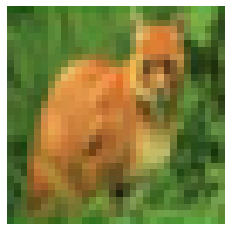

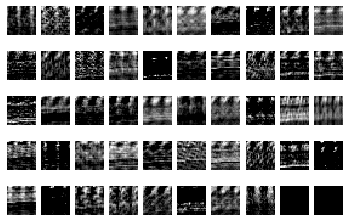

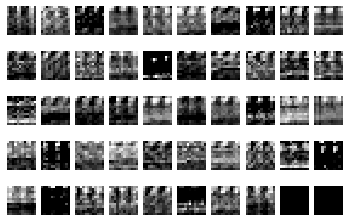

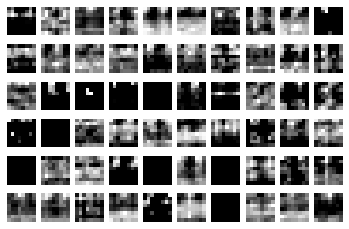

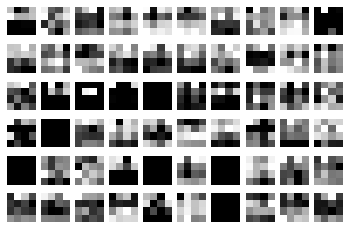

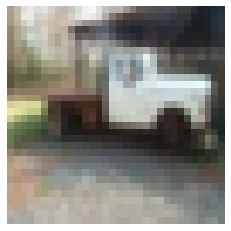

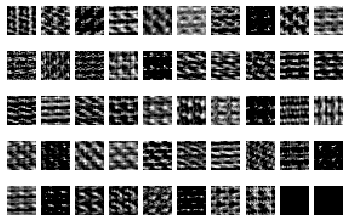

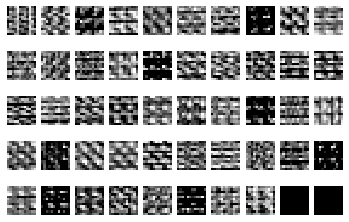

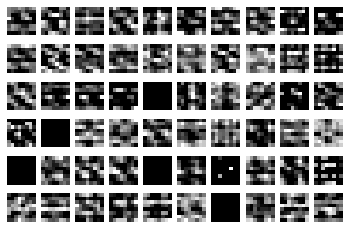

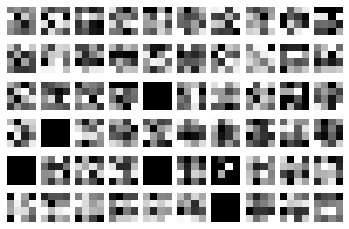

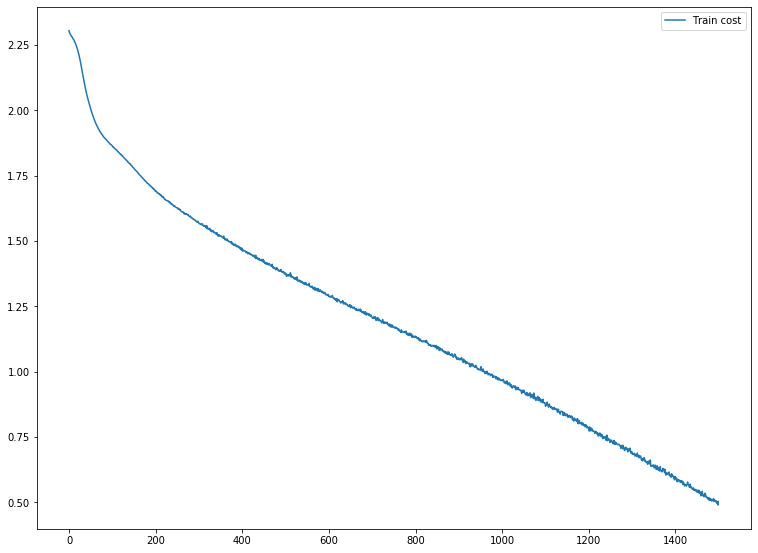

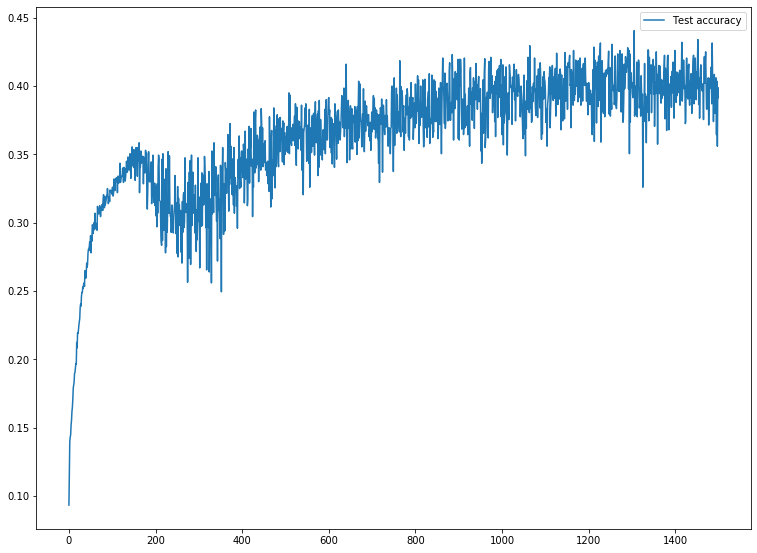

In [0]:
# Q1
conv_1, pool_1, conv_2, pool_2, logits, _ = cnn(x, 50, 60)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(trainX)
idx = np.arange(N)

train_cost = []
test_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for e in tqdm(range(epochs)):
        np.random.shuffle(idx)
        train_X, train_Y = trainX[idx], trainY[idx]
        train_cost_ = []
        # Handle in batches
        for start, end in zip(range(0, len(train_X), batch_size), range(batch_size, len(train_X), batch_size)):
            _, batch_cost = sess.run([train_step, loss], {x: train_X[start:end], y_: train_Y[start:end]})
            train_cost_.append(batch_cost)
        train_cost.append(np.mean(np.array(train_cost_), axis=0))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
        if e % 10 == 0:
            print('epoch', e, 'accuracy', test_acc[e])

    # Plot feature maps
    for i in range(2):
        ind = np.random.randint(low=0, high=10000)
        X = trainX[ind,:]
        conv_1_, pool_1_, conv_2_, pool_2_ = sess.run([conv_1, pool_1, conv_2, pool_2],
                                                    {x: X.reshape(1,IMG_SIZE*IMG_SIZE*NUM_CHANNELS)})
        plot_feature_maps(X, conv_1_, pool_1_, conv_2_, pool_2_, i)

plot_cost('partA_plots/q1a_1.png', epochs, train_cost)
plot_acc('partA_plots/q1a_2.png', epochs, test_acc)

epoch 0 accuracy 0.103
epoch 10 accuracy 0.194
epoch 20 accuracy 0.2535
epoch 30 accuracy 0.2785
epoch 40 accuracy 0.2875
epoch 50 accuracy 0.3005
epoch 60 accuracy 0.324
epoch 70 accuracy 0.3275
epoch 80 accuracy 0.3265
epoch 90 accuracy 0.333
epoch 100 accuracy 0.348
epoch 110 accuracy 0.341
epoch 120 accuracy 0.3455
epoch 130 accuracy 0.3545
epoch 140 accuracy 0.3505
epoch 150 accuracy 0.337
epoch 160 accuracy 0.3535
epoch 170 accuracy 0.3305
epoch 180 accuracy 0.335
epoch 190 accuracy 0.325
epoch 200 accuracy 0.305
epoch 210 accuracy 0.3135
epoch 220 accuracy 0.3215
epoch 230 accuracy 0.317
epoch 240 accuracy 0.3225
epoch 250 accuracy 0.292
epoch 260 accuracy 0.3135
epoch 270 accuracy 0.3055
epoch 280 accuracy 0.315
epoch 290 accuracy 0.316
epoch 300 accuracy 0.321
epoch 310 accuracy 0.3275
epoch 320 accuracy 0.315
epoch 330 accuracy 0.3235
epoch 340 accuracy 0.31
epoch 350 accuracy 0.323
epoch 360 accuracy 0.327
epoch 370 accuracy 0.3385
epoch 380 accuracy 0.3445
epoch 390 accurac

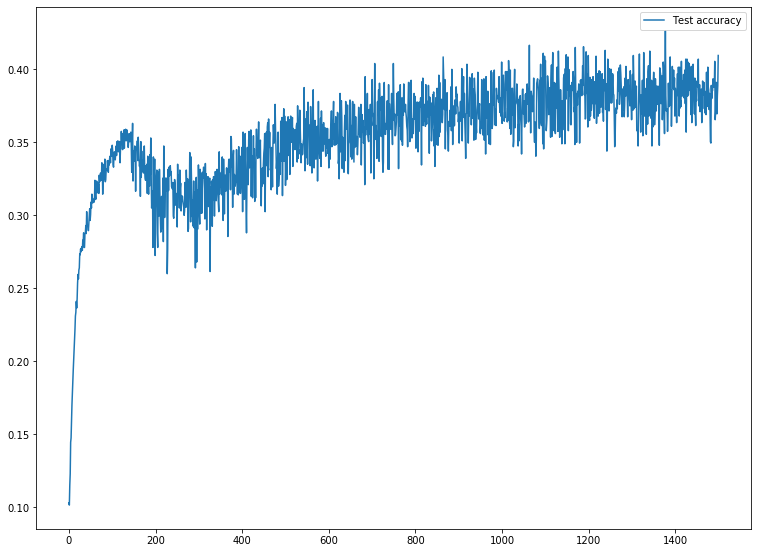

epoch 0 accuracy 0.1145
epoch 10 accuracy 0.1785
epoch 20 accuracy 0.222
epoch 30 accuracy 0.2435
epoch 40 accuracy 0.264
epoch 50 accuracy 0.2865
epoch 60 accuracy 0.301
epoch 70 accuracy 0.31
epoch 80 accuracy 0.3145
epoch 90 accuracy 0.3165
epoch 100 accuracy 0.3195
epoch 110 accuracy 0.3255
epoch 120 accuracy 0.3235
epoch 130 accuracy 0.3205
epoch 140 accuracy 0.3235
epoch 150 accuracy 0.327
epoch 160 accuracy 0.323
epoch 170 accuracy 0.329
epoch 180 accuracy 0.314
epoch 190 accuracy 0.2855
epoch 200 accuracy 0.2745
epoch 210 accuracy 0.3055
epoch 220 accuracy 0.2895
epoch 230 accuracy 0.244
epoch 240 accuracy 0.2655
epoch 250 accuracy 0.297
epoch 260 accuracy 0.2585
epoch 270 accuracy 0.283
epoch 280 accuracy 0.2825
epoch 290 accuracy 0.2975
epoch 300 accuracy 0.2885
epoch 310 accuracy 0.2615
epoch 320 accuracy 0.3085
epoch 330 accuracy 0.302
epoch 340 accuracy 0.273
epoch 350 accuracy 0.298
epoch 360 accuracy 0.2805
epoch 370 accuracy 0.301
epoch 380 accuracy 0.3025
epoch 390 acc

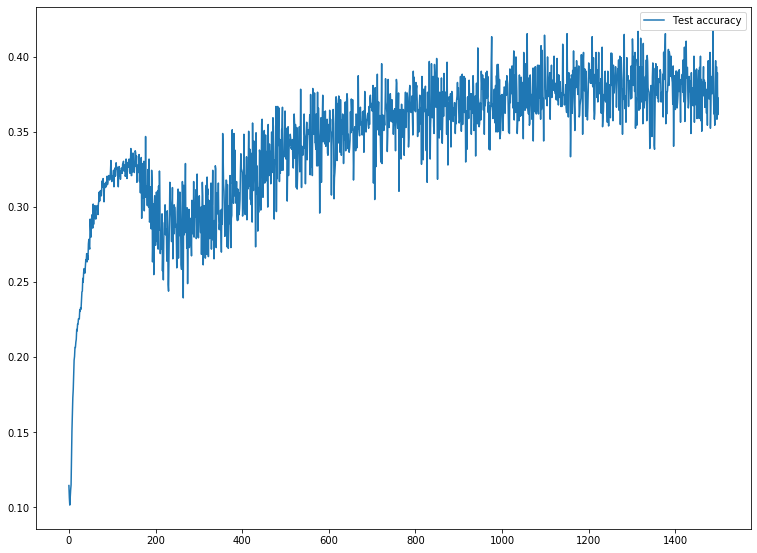

epoch 0 accuracy 0.105
epoch 10 accuracy 0.1895
epoch 20 accuracy 0.2335
epoch 30 accuracy 0.2485
epoch 40 accuracy 0.2855
epoch 50 accuracy 0.293
epoch 60 accuracy 0.295
epoch 70 accuracy 0.307
epoch 80 accuracy 0.3145
epoch 90 accuracy 0.317
epoch 100 accuracy 0.337
epoch 110 accuracy 0.3415
epoch 120 accuracy 0.3375
epoch 130 accuracy 0.347
epoch 140 accuracy 0.353
epoch 150 accuracy 0.3575
epoch 160 accuracy 0.3625
epoch 170 accuracy 0.3575
epoch 180 accuracy 0.3665
epoch 190 accuracy 0.38
epoch 200 accuracy 0.359
epoch 210 accuracy 0.3505
epoch 220 accuracy 0.3595
epoch 230 accuracy 0.358
epoch 240 accuracy 0.3365
epoch 250 accuracy 0.3725
epoch 260 accuracy 0.3765
epoch 270 accuracy 0.331
epoch 280 accuracy 0.348
epoch 290 accuracy 0.3305
epoch 300 accuracy 0.3415
epoch 310 accuracy 0.334
epoch 320 accuracy 0.298
epoch 330 accuracy 0.3025
epoch 340 accuracy 0.3655
epoch 350 accuracy 0.326
epoch 360 accuracy 0.339
epoch 370 accuracy 0.304
epoch 380 accuracy 0.3495
epoch 390 accura

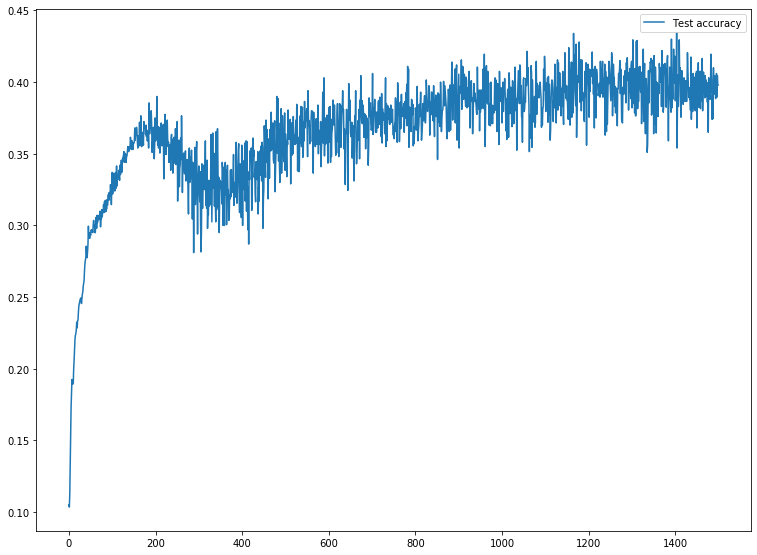

epoch 0 accuracy 0.1
epoch 10 accuracy 0.159
epoch 20 accuracy 0.2195
epoch 30 accuracy 0.2495
epoch 40 accuracy 0.272
epoch 50 accuracy 0.287
epoch 60 accuracy 0.292
epoch 70 accuracy 0.3005
epoch 80 accuracy 0.305
epoch 90 accuracy 0.3135
epoch 100 accuracy 0.3125
epoch 110 accuracy 0.322
epoch 120 accuracy 0.3255
epoch 130 accuracy 0.3305
epoch 140 accuracy 0.3355
epoch 150 accuracy 0.3395
epoch 160 accuracy 0.3415
epoch 170 accuracy 0.353
epoch 180 accuracy 0.3355
epoch 190 accuracy 0.339
epoch 200 accuracy 0.3375
epoch 210 accuracy 0.315
epoch 220 accuracy 0.3225
epoch 230 accuracy 0.337
epoch 240 accuracy 0.3145
epoch 250 accuracy 0.2985
epoch 260 accuracy 0.3165
epoch 270 accuracy 0.311
epoch 280 accuracy 0.28
epoch 290 accuracy 0.3175
epoch 300 accuracy 0.302
epoch 310 accuracy 0.2875
epoch 320 accuracy 0.31
epoch 330 accuracy 0.331
epoch 340 accuracy 0.3175
epoch 350 accuracy 0.3245
epoch 360 accuracy 0.3315
epoch 370 accuracy 0.323
epoch 380 accuracy 0.3445
epoch 390 accuracy

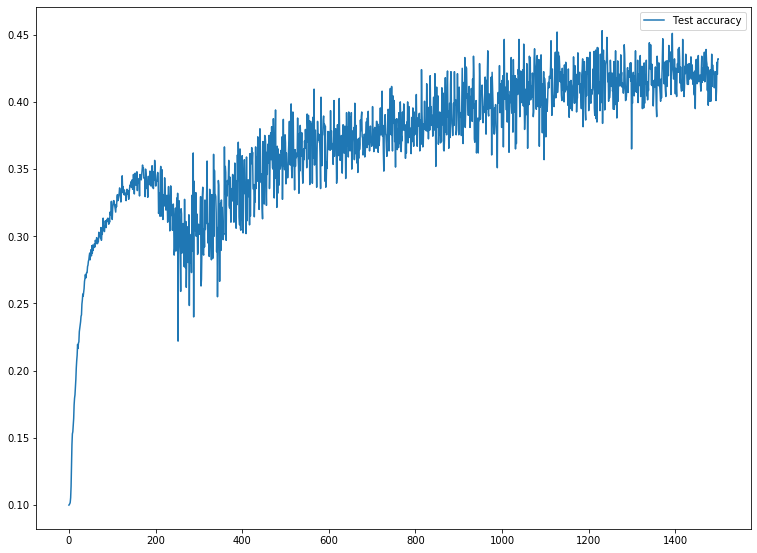

epoch 0 accuracy 0.1055
epoch 10 accuracy 0.1915
epoch 20 accuracy 0.2325
epoch 30 accuracy 0.2605
epoch 40 accuracy 0.2855
epoch 50 accuracy 0.3045
epoch 60 accuracy 0.308
epoch 70 accuracy 0.3085
epoch 80 accuracy 0.32
epoch 90 accuracy 0.3165
epoch 100 accuracy 0.333
epoch 110 accuracy 0.3265
epoch 120 accuracy 0.336
epoch 130 accuracy 0.337
epoch 140 accuracy 0.349
epoch 150 accuracy 0.349
epoch 160 accuracy 0.35
epoch 170 accuracy 0.332
epoch 180 accuracy 0.326
epoch 190 accuracy 0.3545
epoch 200 accuracy 0.3345
epoch 210 accuracy 0.3445
epoch 220 accuracy 0.326
epoch 230 accuracy 0.3235
epoch 240 accuracy 0.3005
epoch 250 accuracy 0.296
epoch 260 accuracy 0.3175
epoch 270 accuracy 0.264
epoch 280 accuracy 0.307
epoch 290 accuracy 0.3305
epoch 300 accuracy 0.333
epoch 310 accuracy 0.321
epoch 320 accuracy 0.3285
epoch 330 accuracy 0.328
epoch 340 accuracy 0.3305
epoch 350 accuracy 0.338
epoch 360 accuracy 0.372
epoch 370 accuracy 0.341
epoch 380 accuracy 0.374
epoch 390 accuracy 0

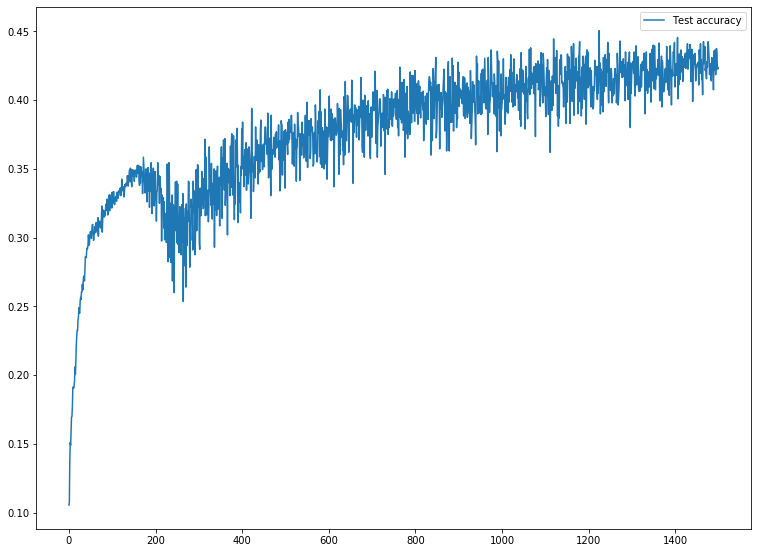

epoch 0 accuracy 0.102
epoch 10 accuracy 0.2165
epoch 20 accuracy 0.2695
epoch 30 accuracy 0.2835
epoch 40 accuracy 0.2985
epoch 50 accuracy 0.3105
epoch 60 accuracy 0.309
epoch 70 accuracy 0.318
epoch 80 accuracy 0.3275
epoch 90 accuracy 0.3185
epoch 100 accuracy 0.3295
epoch 110 accuracy 0.3355
epoch 120 accuracy 0.342
epoch 130 accuracy 0.341
epoch 140 accuracy 0.349
epoch 150 accuracy 0.3555
epoch 160 accuracy 0.3455
epoch 170 accuracy 0.361
epoch 180 accuracy 0.3525
epoch 190 accuracy 0.3365
epoch 200 accuracy 0.3115
epoch 210 accuracy 0.34
epoch 220 accuracy 0.3405
epoch 230 accuracy 0.3335
epoch 240 accuracy 0.326
epoch 250 accuracy 0.3035
epoch 260 accuracy 0.3025
epoch 270 accuracy 0.337
epoch 280 accuracy 0.346
epoch 290 accuracy 0.347
epoch 300 accuracy 0.3295
epoch 310 accuracy 0.3245
epoch 320 accuracy 0.341
epoch 330 accuracy 0.3335
epoch 340 accuracy 0.3355
epoch 350 accuracy 0.37
epoch 360 accuracy 0.326
epoch 370 accuracy 0.308
epoch 380 accuracy 0.3535
epoch 390 accur

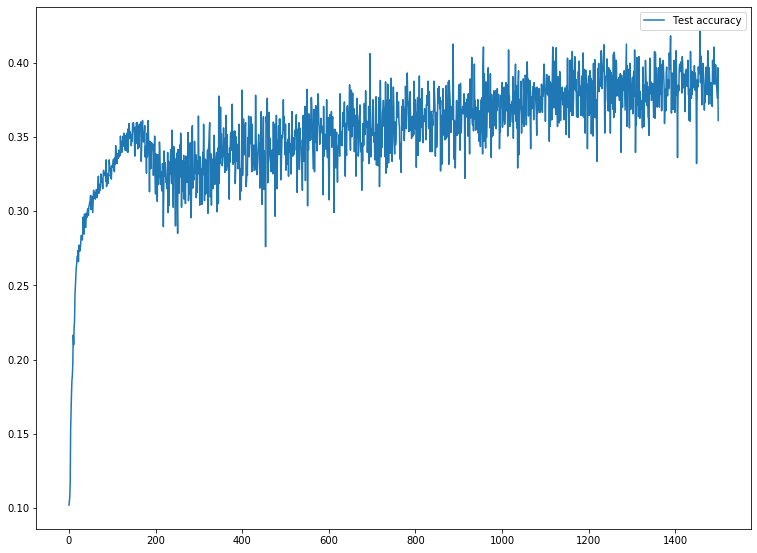

epoch 0 accuracy 0.089
epoch 10 accuracy 0.1885
epoch 20 accuracy 0.222
epoch 30 accuracy 0.246
epoch 40 accuracy 0.2715
epoch 50 accuracy 0.2875
epoch 60 accuracy 0.3015
epoch 70 accuracy 0.31
epoch 80 accuracy 0.3255
epoch 90 accuracy 0.33
epoch 100 accuracy 0.336
epoch 110 accuracy 0.3465
epoch 120 accuracy 0.345
epoch 130 accuracy 0.355
epoch 140 accuracy 0.368
epoch 150 accuracy 0.3625
epoch 160 accuracy 0.367
epoch 170 accuracy 0.3755
epoch 180 accuracy 0.3705
epoch 190 accuracy 0.3615
epoch 200 accuracy 0.347
epoch 210 accuracy 0.3585
epoch 220 accuracy 0.3205
epoch 230 accuracy 0.369
epoch 240 accuracy 0.2885
epoch 250 accuracy 0.3565
epoch 260 accuracy 0.32
epoch 270 accuracy 0.2825
epoch 280 accuracy 0.328
epoch 290 accuracy 0.31
epoch 300 accuracy 0.3185
epoch 310 accuracy 0.311
epoch 320 accuracy 0.322
epoch 330 accuracy 0.319
epoch 340 accuracy 0.2855
epoch 350 accuracy 0.2775
epoch 360 accuracy 0.3335
epoch 370 accuracy 0.3535
epoch 380 accuracy 0.3375
epoch 390 accuracy 

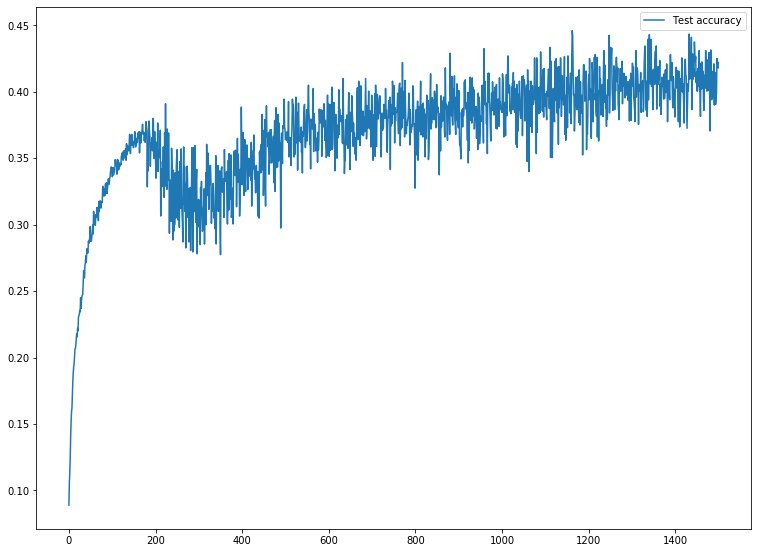

epoch 0 accuracy 0.132
epoch 10 accuracy 0.1875
epoch 20 accuracy 0.226
epoch 30 accuracy 0.278
epoch 40 accuracy 0.282
epoch 50 accuracy 0.2865
epoch 60 accuracy 0.3025
epoch 70 accuracy 0.3125
epoch 80 accuracy 0.3125
epoch 90 accuracy 0.3225
epoch 100 accuracy 0.328
epoch 110 accuracy 0.336
epoch 120 accuracy 0.333
epoch 130 accuracy 0.3465
epoch 140 accuracy 0.359
epoch 150 accuracy 0.342
epoch 160 accuracy 0.3505
epoch 170 accuracy 0.347
epoch 180 accuracy 0.3425
epoch 190 accuracy 0.3575
epoch 200 accuracy 0.338
epoch 210 accuracy 0.339
epoch 220 accuracy 0.337
epoch 230 accuracy 0.313
epoch 240 accuracy 0.319
epoch 250 accuracy 0.328
epoch 260 accuracy 0.319
epoch 270 accuracy 0.299
epoch 280 accuracy 0.31
epoch 290 accuracy 0.314
epoch 300 accuracy 0.284
epoch 310 accuracy 0.32
epoch 320 accuracy 0.327
epoch 330 accuracy 0.2865
epoch 340 accuracy 0.2995
epoch 350 accuracy 0.3115
epoch 360 accuracy 0.3125
epoch 370 accuracy 0.337
epoch 380 accuracy 0.32
epoch 390 accuracy 0.2985

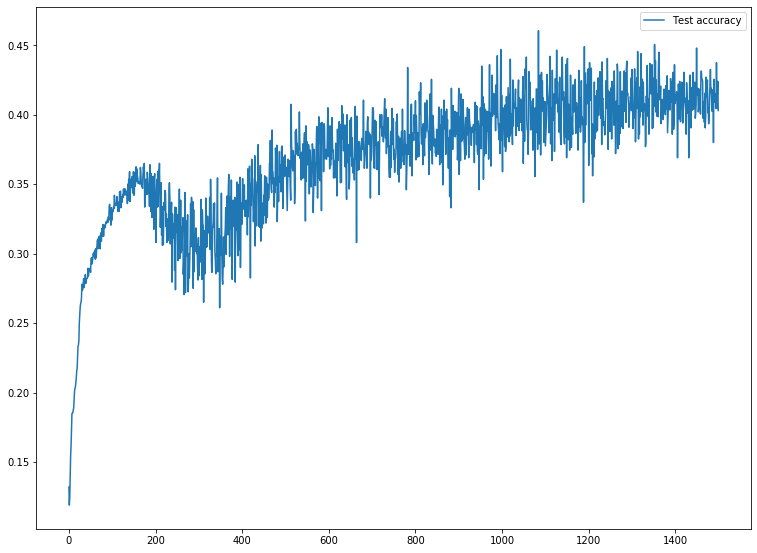

epoch 0 accuracy 0.101
epoch 10 accuracy 0.197
epoch 20 accuracy 0.23
epoch 30 accuracy 0.2475
epoch 40 accuracy 0.269
epoch 50 accuracy 0.2865
epoch 60 accuracy 0.297
epoch 70 accuracy 0.3065
epoch 80 accuracy 0.316
epoch 90 accuracy 0.321
epoch 100 accuracy 0.333
epoch 110 accuracy 0.3285
epoch 120 accuracy 0.3385
epoch 130 accuracy 0.346
epoch 140 accuracy 0.352
epoch 150 accuracy 0.3585
epoch 160 accuracy 0.3585
epoch 170 accuracy 0.3625
epoch 180 accuracy 0.361
epoch 190 accuracy 0.3555
epoch 200 accuracy 0.3535
epoch 210 accuracy 0.359
epoch 220 accuracy 0.366
epoch 230 accuracy 0.3565
epoch 240 accuracy 0.326
epoch 250 accuracy 0.3555
epoch 260 accuracy 0.3205
epoch 270 accuracy 0.3025
epoch 280 accuracy 0.3
epoch 290 accuracy 0.346
epoch 300 accuracy 0.3365
epoch 310 accuracy 0.344
epoch 320 accuracy 0.2945
epoch 330 accuracy 0.348
epoch 340 accuracy 0.3015
epoch 350 accuracy 0.3365
epoch 360 accuracy 0.314
epoch 370 accuracy 0.329
epoch 380 accuracy 0.3295
epoch 390 accuracy 0

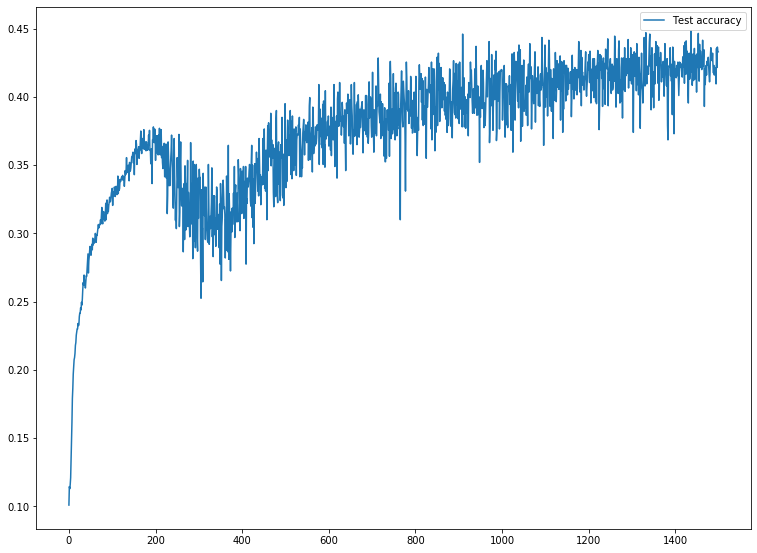

epoch 0 accuracy 0.1075
epoch 10 accuracy 0.1705
epoch 20 accuracy 0.2205
epoch 30 accuracy 0.2525
epoch 40 accuracy 0.281
epoch 50 accuracy 0.2985
epoch 60 accuracy 0.308
epoch 70 accuracy 0.318
epoch 80 accuracy 0.3135
epoch 90 accuracy 0.327
epoch 100 accuracy 0.3305
epoch 110 accuracy 0.34
epoch 120 accuracy 0.3335
epoch 130 accuracy 0.3505
epoch 140 accuracy 0.349
epoch 150 accuracy 0.3555
epoch 160 accuracy 0.365
epoch 170 accuracy 0.3685
epoch 180 accuracy 0.372
epoch 190 accuracy 0.373
epoch 200 accuracy 0.3685
epoch 210 accuracy 0.365
epoch 220 accuracy 0.368
epoch 230 accuracy 0.373
epoch 240 accuracy 0.354
epoch 250 accuracy 0.3415
epoch 260 accuracy 0.3415
epoch 270 accuracy 0.3535
epoch 280 accuracy 0.329
epoch 290 accuracy 0.3085
epoch 300 accuracy 0.3405
epoch 310 accuracy 0.3325
epoch 320 accuracy 0.3225
epoch 330 accuracy 0.314
epoch 340 accuracy 0.316
epoch 350 accuracy 0.3305
epoch 360 accuracy 0.326
epoch 370 accuracy 0.299
epoch 380 accuracy 0.331
epoch 390 accurac

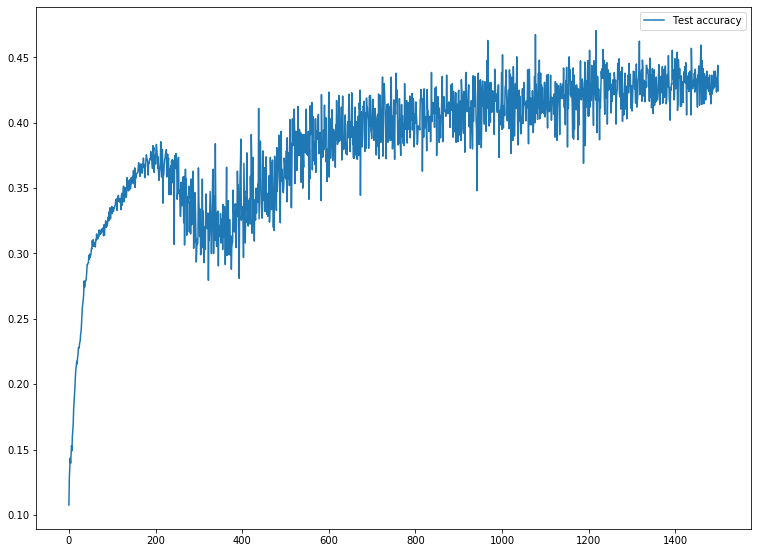

epoch 0 accuracy 0.1285
epoch 10 accuracy 0.248
epoch 20 accuracy 0.2775
epoch 30 accuracy 0.291
epoch 40 accuracy 0.3195
epoch 50 accuracy 0.327
epoch 60 accuracy 0.3345
epoch 70 accuracy 0.353
epoch 80 accuracy 0.3575
epoch 90 accuracy 0.369
epoch 100 accuracy 0.3795
epoch 110 accuracy 0.388
epoch 120 accuracy 0.387
epoch 130 accuracy 0.3825
epoch 140 accuracy 0.394
epoch 150 accuracy 0.401
epoch 160 accuracy 0.379
epoch 170 accuracy 0.3835
epoch 180 accuracy 0.378
epoch 190 accuracy 0.3645
epoch 200 accuracy 0.377
epoch 210 accuracy 0.3655
epoch 220 accuracy 0.356
epoch 230 accuracy 0.353
epoch 240 accuracy 0.361
epoch 250 accuracy 0.368
epoch 260 accuracy 0.38
epoch 270 accuracy 0.346
epoch 280 accuracy 0.3625
epoch 290 accuracy 0.36
epoch 300 accuracy 0.3695
epoch 310 accuracy 0.331
epoch 320 accuracy 0.356
epoch 330 accuracy 0.3645
epoch 340 accuracy 0.3425
epoch 350 accuracy 0.335
epoch 360 accuracy 0.355
epoch 370 accuracy 0.3695
epoch 380 accuracy 0.366
epoch 390 accuracy 0.34

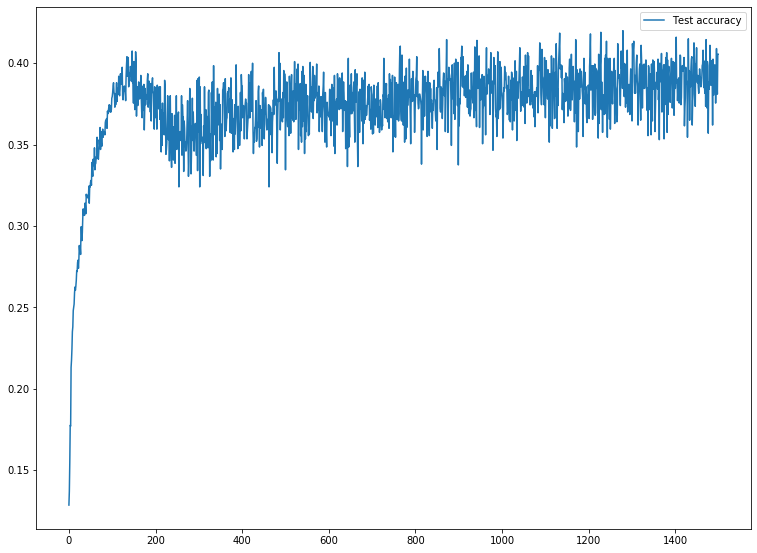

epoch 0 accuracy 0.105
epoch 10 accuracy 0.2
epoch 20 accuracy 0.2365
epoch 30 accuracy 0.276
epoch 40 accuracy 0.3005
epoch 50 accuracy 0.307
epoch 60 accuracy 0.3125
epoch 70 accuracy 0.3275
epoch 80 accuracy 0.334
epoch 90 accuracy 0.346
epoch 100 accuracy 0.3515
epoch 110 accuracy 0.3525
epoch 120 accuracy 0.358
epoch 130 accuracy 0.368
epoch 140 accuracy 0.3715
epoch 150 accuracy 0.378
epoch 160 accuracy 0.3835
epoch 170 accuracy 0.3905
epoch 180 accuracy 0.3845
epoch 190 accuracy 0.3535
epoch 200 accuracy 0.383
epoch 210 accuracy 0.3685
epoch 220 accuracy 0.357
epoch 230 accuracy 0.341
epoch 240 accuracy 0.339
epoch 250 accuracy 0.334
epoch 260 accuracy 0.3705
epoch 270 accuracy 0.344
epoch 280 accuracy 0.358
epoch 290 accuracy 0.346
epoch 300 accuracy 0.3325
epoch 310 accuracy 0.3725
epoch 320 accuracy 0.348
epoch 330 accuracy 0.331
epoch 340 accuracy 0.349
epoch 350 accuracy 0.383
epoch 360 accuracy 0.316
epoch 370 accuracy 0.357
epoch 380 accuracy 0.3225
epoch 390 accuracy 0.3

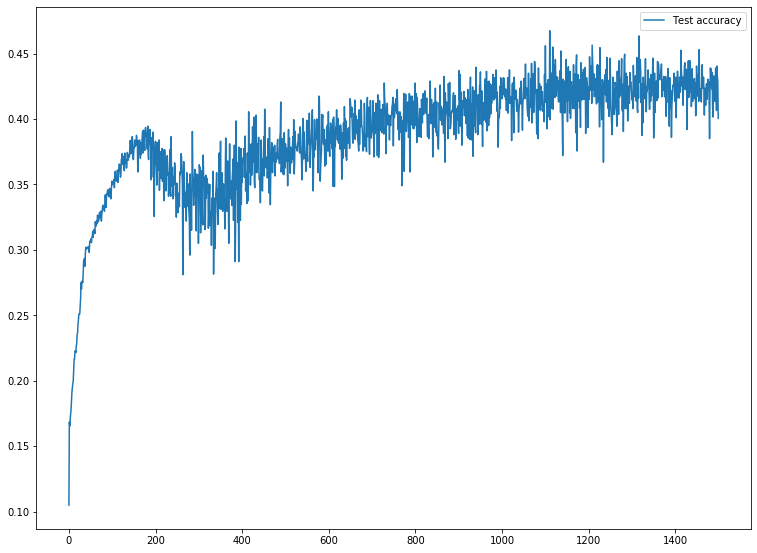

epoch 0 accuracy 0.116
epoch 10 accuracy 0.217
epoch 20 accuracy 0.2445
epoch 30 accuracy 0.2695
epoch 40 accuracy 0.292
epoch 50 accuracy 0.306
epoch 60 accuracy 0.312
epoch 70 accuracy 0.321
epoch 80 accuracy 0.332
epoch 90 accuracy 0.3315
epoch 100 accuracy 0.344
epoch 110 accuracy 0.342
epoch 120 accuracy 0.3555
epoch 130 accuracy 0.3555
epoch 140 accuracy 0.364
epoch 150 accuracy 0.368
epoch 160 accuracy 0.3825
epoch 170 accuracy 0.3875
epoch 180 accuracy 0.379
epoch 190 accuracy 0.3805
epoch 200 accuracy 0.3915
epoch 210 accuracy 0.3505
epoch 220 accuracy 0.3825
epoch 230 accuracy 0.3455
epoch 240 accuracy 0.3615
epoch 250 accuracy 0.361
epoch 260 accuracy 0.368
epoch 270 accuracy 0.356
epoch 280 accuracy 0.3245
epoch 290 accuracy 0.3545
epoch 300 accuracy 0.3645
epoch 310 accuracy 0.353
epoch 320 accuracy 0.3715
epoch 330 accuracy 0.3135
epoch 340 accuracy 0.347
epoch 350 accuracy 0.37
epoch 360 accuracy 0.325
epoch 370 accuracy 0.367
epoch 380 accuracy 0.3795
epoch 390 accuracy

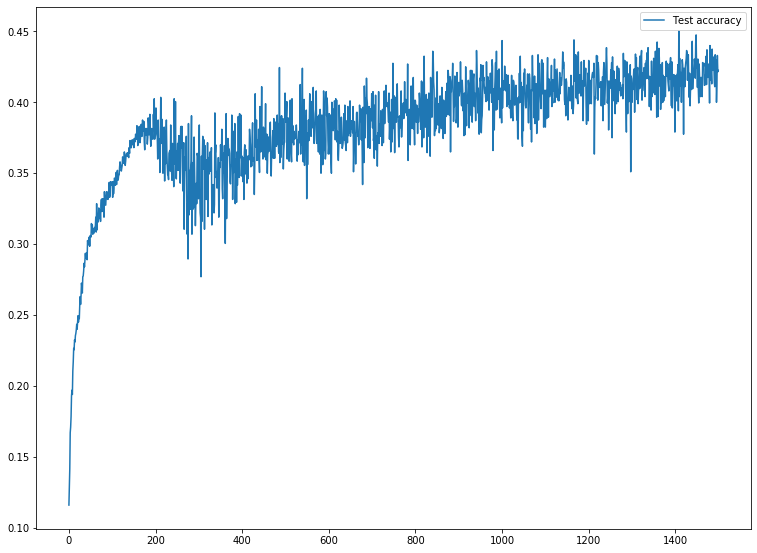

epoch 0 accuracy 0.1515
epoch 10 accuracy 0.183
epoch 20 accuracy 0.222
epoch 30 accuracy 0.2715
epoch 40 accuracy 0.2885
epoch 50 accuracy 0.301
epoch 60 accuracy 0.3075
epoch 70 accuracy 0.3175
epoch 80 accuracy 0.3235
epoch 90 accuracy 0.326
epoch 100 accuracy 0.344
epoch 110 accuracy 0.3415
epoch 120 accuracy 0.349
epoch 130 accuracy 0.3465
epoch 140 accuracy 0.355
epoch 150 accuracy 0.3665
epoch 160 accuracy 0.3695
epoch 170 accuracy 0.372
epoch 180 accuracy 0.3795
epoch 190 accuracy 0.375
epoch 200 accuracy 0.3765
epoch 210 accuracy 0.358
epoch 220 accuracy 0.3755
epoch 230 accuracy 0.389
epoch 240 accuracy 0.343
epoch 250 accuracy 0.365
epoch 260 accuracy 0.341
epoch 270 accuracy 0.348
epoch 280 accuracy 0.323
epoch 290 accuracy 0.329
epoch 300 accuracy 0.314
epoch 310 accuracy 0.332
epoch 320 accuracy 0.3405
epoch 330 accuracy 0.327
epoch 340 accuracy 0.3105
epoch 350 accuracy 0.302
epoch 360 accuracy 0.3495
epoch 370 accuracy 0.308
epoch 380 accuracy 0.3365
epoch 390 accuracy 

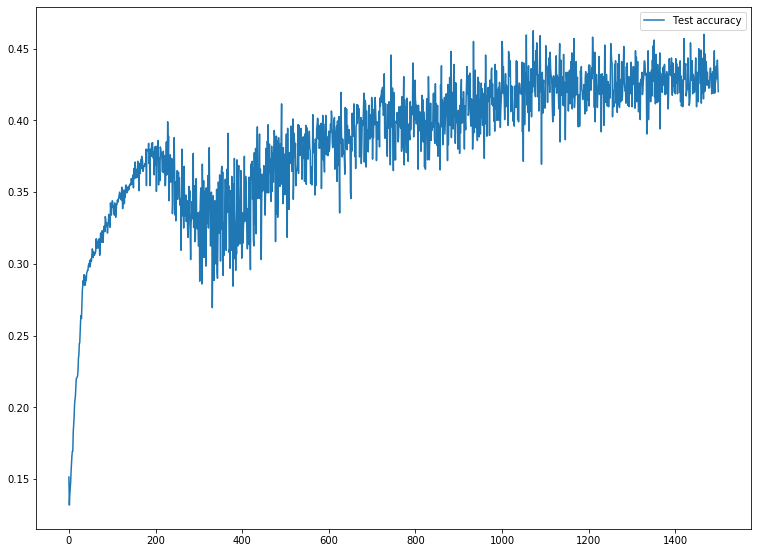

epoch 0 accuracy 0.096
epoch 10 accuracy 0.195
epoch 20 accuracy 0.235
epoch 30 accuracy 0.2715
epoch 40 accuracy 0.289
epoch 50 accuracy 0.2985
epoch 60 accuracy 0.304
epoch 70 accuracy 0.309
epoch 80 accuracy 0.3175
epoch 90 accuracy 0.323
epoch 100 accuracy 0.3335
epoch 110 accuracy 0.3285
epoch 120 accuracy 0.341
epoch 130 accuracy 0.349
epoch 140 accuracy 0.349
epoch 150 accuracy 0.3595
epoch 160 accuracy 0.363
epoch 170 accuracy 0.363
epoch 180 accuracy 0.369
epoch 190 accuracy 0.3675
epoch 200 accuracy 0.373
epoch 210 accuracy 0.3655
epoch 220 accuracy 0.3835
epoch 230 accuracy 0.3595
epoch 240 accuracy 0.362
epoch 250 accuracy 0.354
epoch 260 accuracy 0.3765
epoch 270 accuracy 0.33
epoch 280 accuracy 0.3715
epoch 290 accuracy 0.372
epoch 300 accuracy 0.374
epoch 310 accuracy 0.3335
epoch 320 accuracy 0.317
epoch 330 accuracy 0.341
epoch 340 accuracy 0.369
epoch 350 accuracy 0.363
epoch 360 accuracy 0.3905
epoch 370 accuracy 0.376
epoch 380 accuracy 0.3205
epoch 390 accuracy 0.3

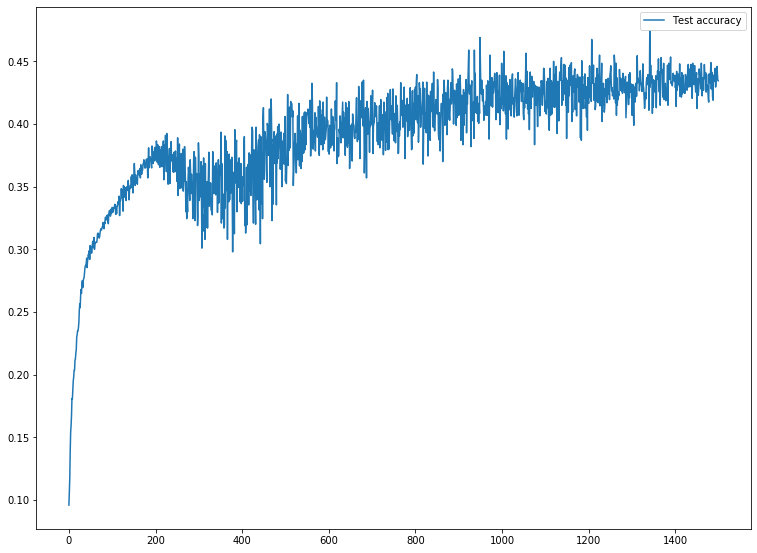

epoch 0 accuracy 0.137
epoch 10 accuracy 0.2455
epoch 20 accuracy 0.301
epoch 30 accuracy 0.3235
epoch 40 accuracy 0.343
epoch 50 accuracy 0.349
epoch 60 accuracy 0.36
epoch 70 accuracy 0.3665
epoch 80 accuracy 0.371
epoch 90 accuracy 0.3795
epoch 100 accuracy 0.393
epoch 110 accuracy 0.402
epoch 120 accuracy 0.3975
epoch 130 accuracy 0.4125
epoch 140 accuracy 0.405
epoch 150 accuracy 0.3835
epoch 160 accuracy 0.3885
epoch 170 accuracy 0.3755
epoch 180 accuracy 0.419
epoch 190 accuracy 0.3475
epoch 200 accuracy 0.3425
epoch 210 accuracy 0.406
epoch 220 accuracy 0.3935
epoch 230 accuracy 0.377
epoch 240 accuracy 0.3515
epoch 250 accuracy 0.323
epoch 260 accuracy 0.383
epoch 270 accuracy 0.354
epoch 280 accuracy 0.3565
epoch 290 accuracy 0.3705
epoch 300 accuracy 0.357
epoch 310 accuracy 0.3825
epoch 320 accuracy 0.3715
epoch 330 accuracy 0.369
epoch 340 accuracy 0.3535
epoch 350 accuracy 0.372
epoch 360 accuracy 0.36
epoch 370 accuracy 0.368
epoch 380 accuracy 0.3725
epoch 390 accuracy 

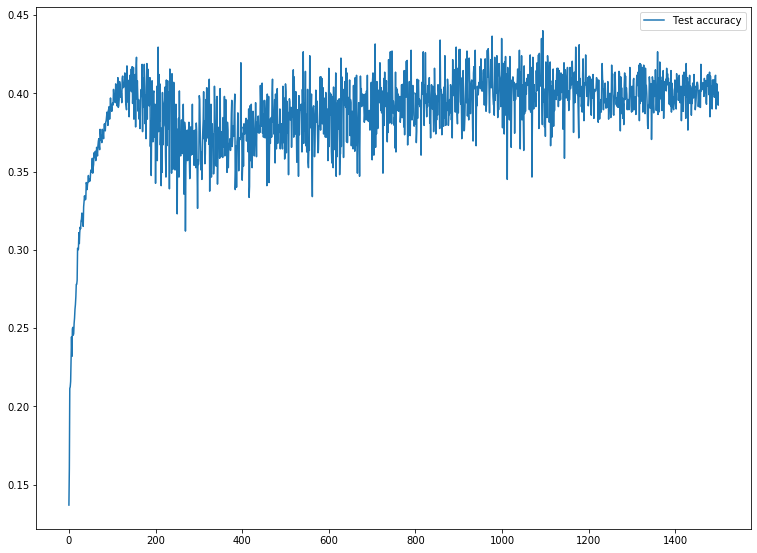

epoch 0 accuracy 0.114
epoch 10 accuracy 0.2485
epoch 20 accuracy 0.29
epoch 30 accuracy 0.311
epoch 40 accuracy 0.3205
epoch 50 accuracy 0.3355
epoch 60 accuracy 0.3435
epoch 70 accuracy 0.351
epoch 80 accuracy 0.359
epoch 90 accuracy 0.3575
epoch 100 accuracy 0.371
epoch 110 accuracy 0.388
epoch 120 accuracy 0.387
epoch 130 accuracy 0.397
epoch 140 accuracy 0.4075
epoch 150 accuracy 0.398
epoch 160 accuracy 0.416
epoch 170 accuracy 0.4
epoch 180 accuracy 0.3925
epoch 190 accuracy 0.4
epoch 200 accuracy 0.396
epoch 210 accuracy 0.401
epoch 220 accuracy 0.412
epoch 230 accuracy 0.398
epoch 240 accuracy 0.4045
epoch 250 accuracy 0.38
epoch 260 accuracy 0.3315
epoch 270 accuracy 0.3875
epoch 280 accuracy 0.3765
epoch 290 accuracy 0.3595
epoch 300 accuracy 0.395
epoch 310 accuracy 0.4155
epoch 320 accuracy 0.368
epoch 330 accuracy 0.3885
epoch 340 accuracy 0.427
epoch 350 accuracy 0.401
epoch 360 accuracy 0.3705
epoch 370 accuracy 0.423
epoch 380 accuracy 0.401
epoch 390 accuracy 0.3965
e

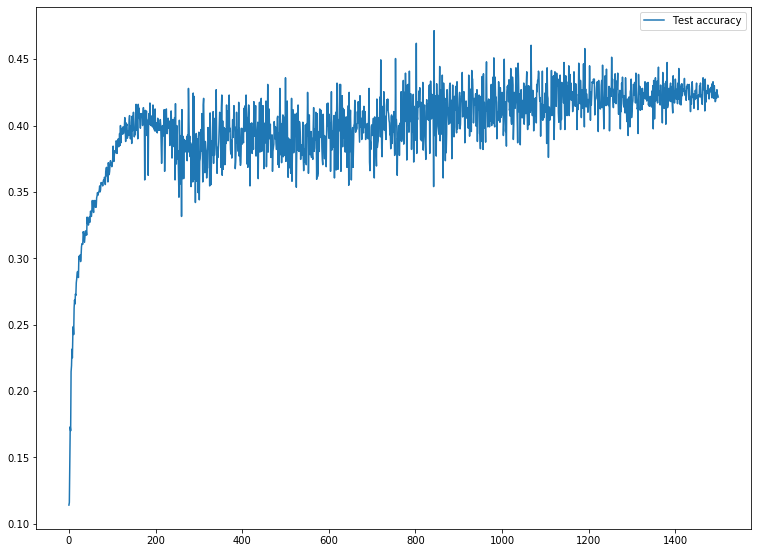

epoch 0 accuracy 0.1045
epoch 10 accuracy 0.226
epoch 20 accuracy 0.2665
epoch 30 accuracy 0.281
epoch 40 accuracy 0.3125
epoch 50 accuracy 0.3135
epoch 60 accuracy 0.3215
epoch 70 accuracy 0.3335
epoch 80 accuracy 0.3455
epoch 90 accuracy 0.347
epoch 100 accuracy 0.362
epoch 110 accuracy 0.3675
epoch 120 accuracy 0.3755
epoch 130 accuracy 0.3835
epoch 140 accuracy 0.3885
epoch 150 accuracy 0.3965
epoch 160 accuracy 0.4055
epoch 170 accuracy 0.388
epoch 180 accuracy 0.393
epoch 190 accuracy 0.4135
epoch 200 accuracy 0.374
epoch 210 accuracy 0.3925
epoch 220 accuracy 0.3935
epoch 230 accuracy 0.405
epoch 240 accuracy 0.3875
epoch 250 accuracy 0.4035
epoch 260 accuracy 0.3765
epoch 270 accuracy 0.381
epoch 280 accuracy 0.392
epoch 290 accuracy 0.381
epoch 300 accuracy 0.374
epoch 310 accuracy 0.386
epoch 320 accuracy 0.314
epoch 330 accuracy 0.4065
epoch 340 accuracy 0.3745
epoch 350 accuracy 0.416
epoch 360 accuracy 0.406
epoch 370 accuracy 0.3935
epoch 380 accuracy 0.3875
epoch 390 acc

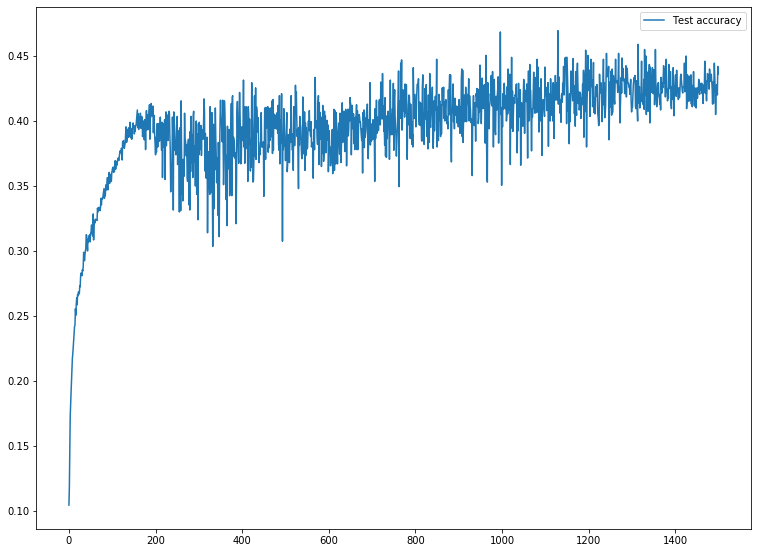

epoch 0 accuracy 0.11
epoch 10 accuracy 0.2075
epoch 20 accuracy 0.2535
epoch 30 accuracy 0.272
epoch 40 accuracy 0.297
epoch 50 accuracy 0.3045
epoch 60 accuracy 0.315
epoch 70 accuracy 0.312
epoch 80 accuracy 0.33
epoch 90 accuracy 0.3375
epoch 100 accuracy 0.3455
epoch 110 accuracy 0.35
epoch 120 accuracy 0.362
epoch 130 accuracy 0.367
epoch 140 accuracy 0.3715
epoch 150 accuracy 0.3865
epoch 160 accuracy 0.3955
epoch 170 accuracy 0.3965
epoch 180 accuracy 0.3975
epoch 190 accuracy 0.39
epoch 200 accuracy 0.4
epoch 210 accuracy 0.357
epoch 220 accuracy 0.387
epoch 230 accuracy 0.395
epoch 240 accuracy 0.394
epoch 250 accuracy 0.4035
epoch 260 accuracy 0.393
epoch 270 accuracy 0.3905
epoch 280 accuracy 0.3805
epoch 290 accuracy 0.367
epoch 300 accuracy 0.395
epoch 310 accuracy 0.364
epoch 320 accuracy 0.366
epoch 330 accuracy 0.3725
epoch 340 accuracy 0.321
epoch 350 accuracy 0.323
epoch 360 accuracy 0.3845
epoch 370 accuracy 0.385
epoch 380 accuracy 0.3875
epoch 390 accuracy 0.3665


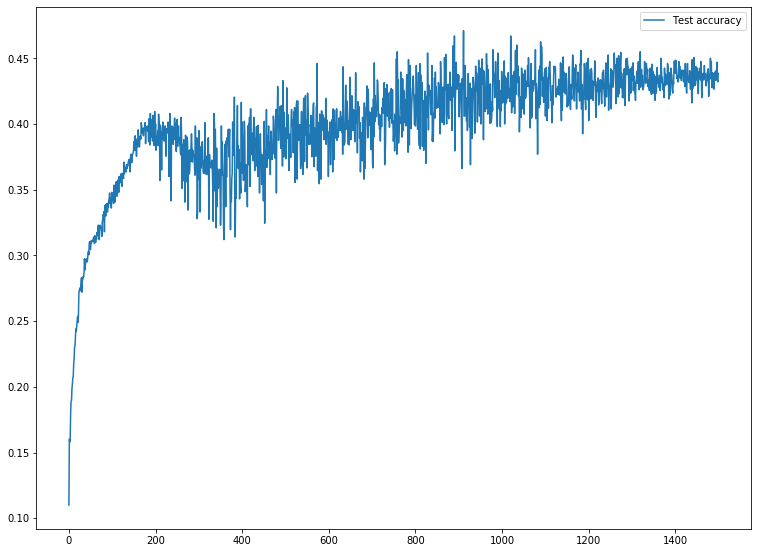

epoch 0 accuracy 0.1
epoch 10 accuracy 0.197
epoch 20 accuracy 0.2445
epoch 30 accuracy 0.279
epoch 40 accuracy 0.29
epoch 50 accuracy 0.3035
epoch 60 accuracy 0.3145
epoch 70 accuracy 0.3145
epoch 80 accuracy 0.318
epoch 90 accuracy 0.3345
epoch 100 accuracy 0.332
epoch 110 accuracy 0.3475
epoch 120 accuracy 0.3485
epoch 130 accuracy 0.3545
epoch 140 accuracy 0.3675
epoch 150 accuracy 0.3675
epoch 160 accuracy 0.3805
epoch 170 accuracy 0.368
epoch 180 accuracy 0.382
epoch 190 accuracy 0.3935
epoch 200 accuracy 0.3985
epoch 210 accuracy 0.3995
epoch 220 accuracy 0.3935
epoch 230 accuracy 0.3875
epoch 240 accuracy 0.3845
epoch 250 accuracy 0.3875
epoch 260 accuracy 0.392
epoch 270 accuracy 0.382
epoch 280 accuracy 0.396
epoch 290 accuracy 0.3575
epoch 300 accuracy 0.358
epoch 310 accuracy 0.319
epoch 320 accuracy 0.3965
epoch 330 accuracy 0.42
epoch 340 accuracy 0.4005
epoch 350 accuracy 0.3785
epoch 360 accuracy 0.411
epoch 370 accuracy 0.4
epoch 380 accuracy 0.3525
epoch 390 accuracy 

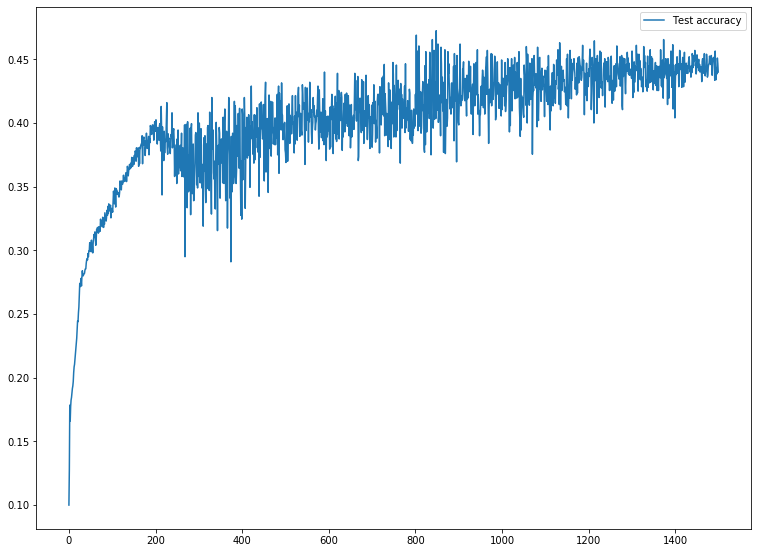

epoch 0 accuracy 0.126
epoch 10 accuracy 0.297
epoch 20 accuracy 0.329
epoch 30 accuracy 0.35
epoch 40 accuracy 0.3685
epoch 50 accuracy 0.3805
epoch 60 accuracy 0.395
epoch 70 accuracy 0.3845
epoch 80 accuracy 0.4055
epoch 90 accuracy 0.414
epoch 100 accuracy 0.4265
epoch 110 accuracy 0.4235
epoch 120 accuracy 0.4215
epoch 130 accuracy 0.444
epoch 140 accuracy 0.434
epoch 150 accuracy 0.4255
epoch 160 accuracy 0.4395
epoch 170 accuracy 0.437
epoch 180 accuracy 0.4475
epoch 190 accuracy 0.4605
epoch 200 accuracy 0.467
epoch 210 accuracy 0.4625
epoch 220 accuracy 0.402
epoch 230 accuracy 0.4685
epoch 240 accuracy 0.437
epoch 250 accuracy 0.4595
epoch 260 accuracy 0.4105
epoch 270 accuracy 0.444
epoch 280 accuracy 0.446
epoch 290 accuracy 0.4275
epoch 300 accuracy 0.4175
epoch 310 accuracy 0.433
epoch 320 accuracy 0.415
epoch 330 accuracy 0.4075
epoch 340 accuracy 0.425
epoch 350 accuracy 0.4305
epoch 360 accuracy 0.421
epoch 370 accuracy 0.449
epoch 380 accuracy 0.409
epoch 390 accuracy

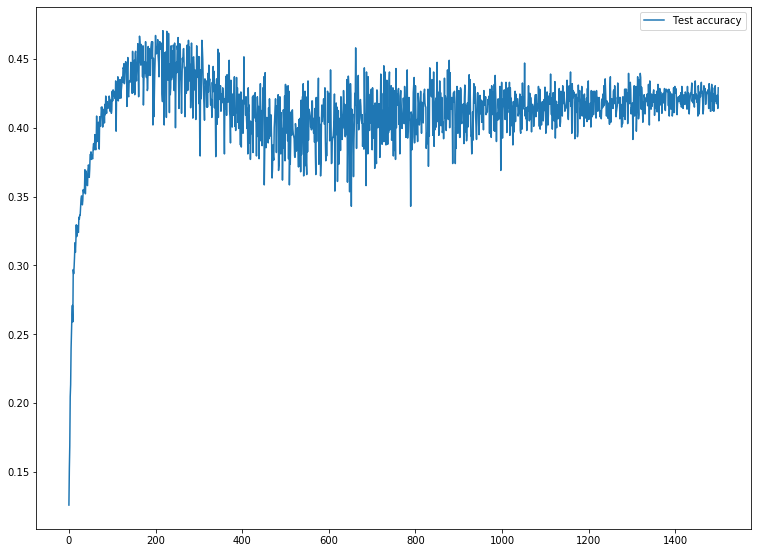

epoch 0 accuracy 0.1415
epoch 10 accuracy 0.261
epoch 20 accuracy 0.309
epoch 30 accuracy 0.321
epoch 40 accuracy 0.3415
epoch 50 accuracy 0.3615
epoch 60 accuracy 0.369
epoch 70 accuracy 0.376
epoch 80 accuracy 0.3955
epoch 90 accuracy 0.4025
epoch 100 accuracy 0.4095
epoch 110 accuracy 0.4115
epoch 120 accuracy 0.4225
epoch 130 accuracy 0.4215
epoch 140 accuracy 0.425
epoch 150 accuracy 0.431
epoch 160 accuracy 0.424
epoch 170 accuracy 0.4335
epoch 180 accuracy 0.429
epoch 190 accuracy 0.4585
epoch 200 accuracy 0.439
epoch 210 accuracy 0.4455
epoch 220 accuracy 0.4365
epoch 230 accuracy 0.4415
epoch 240 accuracy 0.446
epoch 250 accuracy 0.4535
epoch 260 accuracy 0.4125
epoch 270 accuracy 0.4495
epoch 280 accuracy 0.467
epoch 290 accuracy 0.4655
epoch 300 accuracy 0.4475
epoch 310 accuracy 0.4325
epoch 320 accuracy 0.467
epoch 330 accuracy 0.436
epoch 340 accuracy 0.423
epoch 350 accuracy 0.462
epoch 360 accuracy 0.4235
epoch 370 accuracy 0.455
epoch 380 accuracy 0.4315
epoch 390 accu

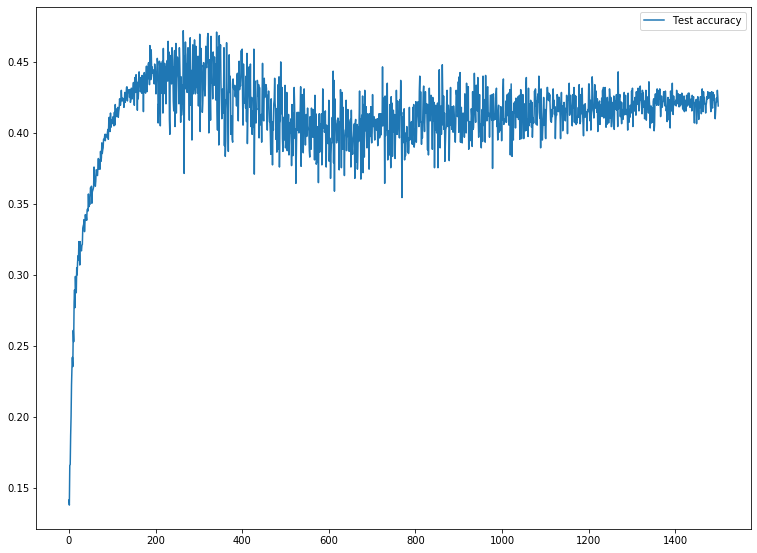

epoch 0 accuracy 0.1265
epoch 10 accuracy 0.239
epoch 20 accuracy 0.2915
epoch 30 accuracy 0.3175
epoch 40 accuracy 0.336
epoch 50 accuracy 0.335
epoch 60 accuracy 0.3545
epoch 70 accuracy 0.3615
epoch 80 accuracy 0.369
epoch 90 accuracy 0.38
epoch 100 accuracy 0.3925
epoch 110 accuracy 0.402
epoch 120 accuracy 0.414
epoch 130 accuracy 0.4055
epoch 140 accuracy 0.4145
epoch 150 accuracy 0.43
epoch 160 accuracy 0.436
epoch 170 accuracy 0.434
epoch 180 accuracy 0.443
epoch 190 accuracy 0.433
epoch 200 accuracy 0.4485
epoch 210 accuracy 0.4295
epoch 220 accuracy 0.44
epoch 230 accuracy 0.452
epoch 240 accuracy 0.433
epoch 250 accuracy 0.4205
epoch 260 accuracy 0.414
epoch 270 accuracy 0.4525
epoch 280 accuracy 0.4335
epoch 290 accuracy 0.4655
epoch 300 accuracy 0.4285
epoch 310 accuracy 0.4325
epoch 320 accuracy 0.4435
epoch 330 accuracy 0.43
epoch 340 accuracy 0.4585
epoch 350 accuracy 0.417
epoch 360 accuracy 0.4555
epoch 370 accuracy 0.416
epoch 380 accuracy 0.4105
epoch 390 accuracy 0

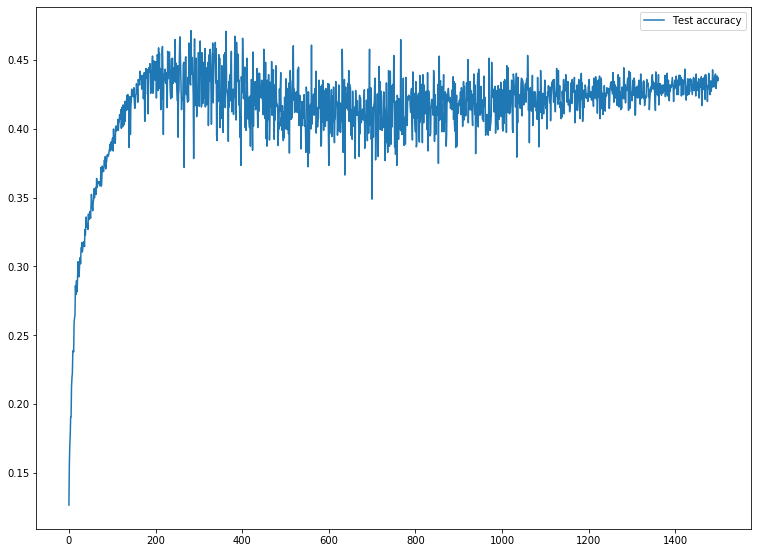

epoch 0 accuracy 0.111
epoch 10 accuracy 0.228
epoch 20 accuracy 0.2715
epoch 30 accuracy 0.297
epoch 40 accuracy 0.3095
epoch 50 accuracy 0.326
epoch 60 accuracy 0.332
epoch 70 accuracy 0.3395
epoch 80 accuracy 0.3465
epoch 90 accuracy 0.3585
epoch 100 accuracy 0.3715
epoch 110 accuracy 0.376
epoch 120 accuracy 0.39
epoch 130 accuracy 0.3945
epoch 140 accuracy 0.4045
epoch 150 accuracy 0.409
epoch 160 accuracy 0.421
epoch 170 accuracy 0.4245
epoch 180 accuracy 0.4175
epoch 190 accuracy 0.4145
epoch 200 accuracy 0.436
epoch 210 accuracy 0.4025
epoch 220 accuracy 0.4395
epoch 230 accuracy 0.4275
epoch 240 accuracy 0.425
epoch 250 accuracy 0.4405
epoch 260 accuracy 0.4545
epoch 270 accuracy 0.419
epoch 280 accuracy 0.4485
epoch 290 accuracy 0.4315
epoch 300 accuracy 0.4435
epoch 310 accuracy 0.4435
epoch 320 accuracy 0.431
epoch 330 accuracy 0.4245
epoch 340 accuracy 0.4465
epoch 350 accuracy 0.434
epoch 360 accuracy 0.4505
epoch 370 accuracy 0.4175
epoch 380 accuracy 0.4285
epoch 390 ac

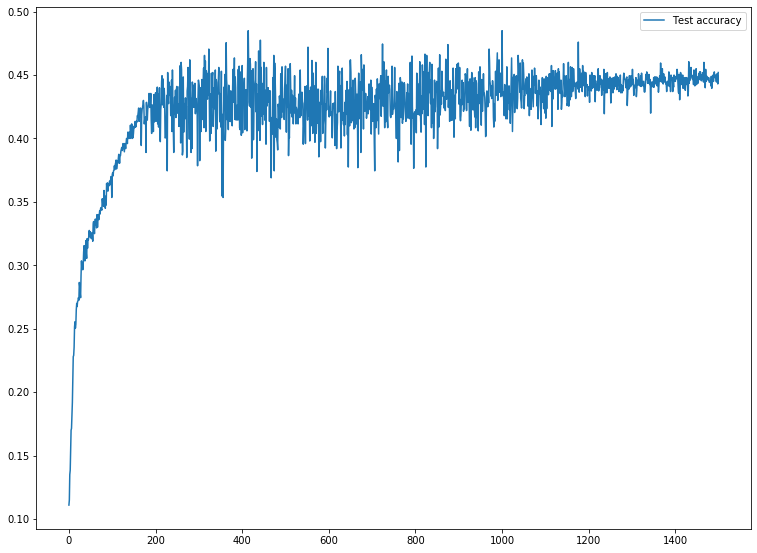

epoch 0 accuracy 0.105
epoch 10 accuracy 0.215
epoch 20 accuracy 0.261
epoch 30 accuracy 0.2885
epoch 40 accuracy 0.304
epoch 50 accuracy 0.3145
epoch 60 accuracy 0.326
epoch 70 accuracy 0.335
epoch 80 accuracy 0.3495
epoch 90 accuracy 0.3605
epoch 100 accuracy 0.3595
epoch 110 accuracy 0.364
epoch 120 accuracy 0.377
epoch 130 accuracy 0.385
epoch 140 accuracy 0.3955
epoch 150 accuracy 0.3985
epoch 160 accuracy 0.408
epoch 170 accuracy 0.423
epoch 180 accuracy 0.429
epoch 190 accuracy 0.43
epoch 200 accuracy 0.421
epoch 210 accuracy 0.408
epoch 220 accuracy 0.415
epoch 230 accuracy 0.4075
epoch 240 accuracy 0.406
epoch 250 accuracy 0.4275
epoch 260 accuracy 0.371
epoch 270 accuracy 0.417
epoch 280 accuracy 0.4345
epoch 290 accuracy 0.4035
epoch 300 accuracy 0.4105
epoch 310 accuracy 0.448
epoch 320 accuracy 0.432
epoch 330 accuracy 0.4095
epoch 340 accuracy 0.4015
epoch 350 accuracy 0.4135
epoch 360 accuracy 0.402
epoch 370 accuracy 0.416
epoch 380 accuracy 0.364
epoch 390 accuracy 0.4

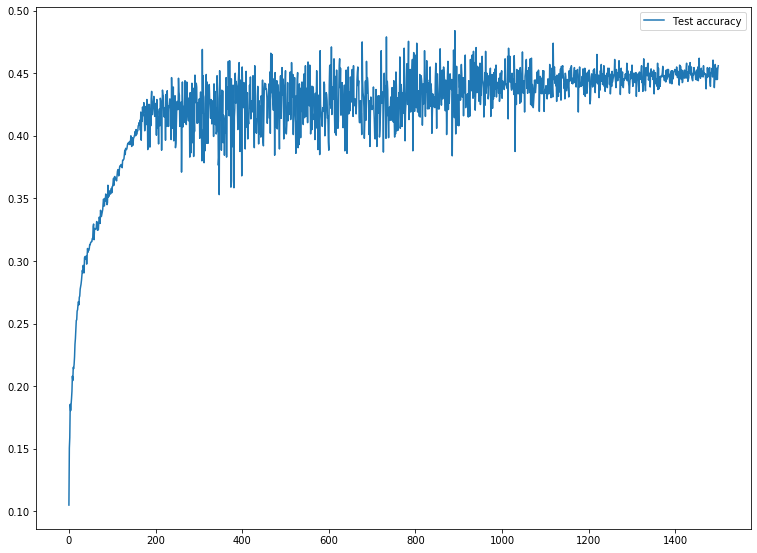

In [0]:
# Q2
layer_1_search = [32,64,128,256,512]
layer_2_search = [32,64,128,256,512]

for i in layer_1_search:
    for j in layer_2_search:
        conv_1, pool_1, conv_2, pool_2, logits, _ = cnn(x, i, j)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
        loss = tf.reduce_mean(cross_entropy)
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)

        N = len(trainX)
        idx = np.arange(N)

        test_acc = []

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for e in tqdm(range(epochs)):
                np.random.shuffle(idx)
                train_X, train_Y = trainX[idx], trainY[idx]
                # Handle in batches
                for start, end in zip(range(0, len(train_X), batch_size), range(batch_size, len(train_X), batch_size)):
                    sess.run([train_step, loss], {x: train_X[start:end], y_: train_Y[start:end]})
                test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
                if e % 10 == 0:
                    print('epoch', e, 'accuracy', test_acc[e])

        plot_acc(f'partA_plots/q2_{i}_{j}.png', epochs, test_acc)

In [0]:
# With dropout
conv_1, pool_1, conv_2, pool_2, logits, _ = cnn(x, 50, 60)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(trainX)
idx = np.arange(N)

test_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for e in tqdm(range(epochs)):
        np.random.shuffle(idx)
        train_X, train_Y = trainX[idx], trainY[idx]
        # Handle in batches
        for start, end in zip(range(0, len(train_X), batch_size), range(batch_size, len(train_X), batch_size)):
            sess.run([train_step, loss], {x: train_X[start:end], y_: train_Y[start:end], keep_prob: 0.5})
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY, keep_prob: 0.5}))
        if e % 10 == 0:
            print('epoch', e, 'accuracy', test_acc[e])